In [3]:
import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def connection_trim_ag(filename):
    rois=pd.read_csv(filename)
    cnx_check = [col for col in rois if 'cnx' in col]
    num_electrodes=len(rois[cnx_check].columns)
    for elect in range(num_electrodes):
        print cnx_check[elect]
        connections=len(rois[rois[cnx_check[elect]]=='excitatory'].index)
        inhib_cons=len(rois[rois[cnx_check[elect]]=='inhibitory'].index)
        tested=len(rois.index)    
        print 'counted '+str(connections)+' excitatory connections out of '+str(tested)+ ' tested'
        print 'counted '+str(inhib_cons)+' inhibitory connections out of '+str(tested)+ ' tested'
        dists=np.zeros((tested,tested))
        count_test=0
        passedROIs=pd.DataFrame()
        skip=[]
        for test_i in rois.index:
            uhoh=0
            neighbors=[test_i]
            for i in rois.index:
                x_dif=rois['X_mm'][i]-rois['X_mm'][test_i]
                y_dif=rois['Y_mm'][i]-rois['Y_mm'][test_i]
                z_dif=rois['Z_mm'][i]-rois['Z_mm'][test_i]
                xyz_dif=math.sqrt(x_dif**2+y_dif**2+z_dif**2)
                dists[test_i,i]=xyz_dif
                if test_i!=i and xyz_dif < 10 and i >= count_test:            
                    print 'look out! '+ str(test_i) + ' and '+ str(i) + ' are only '+str(xyz_dif)+ ' microns apart'
                    if rois[cnx_check[elect]][test_i]==rois[cnx_check[elect]][i]:
                        uhoh+=1
                        neighbors.append(i)
                        skip.append(i)
                        print '   both ROIs marked '+ rois[cnx_check[elect]][test_i]

            
   
    
            if test_i not in skip:
                passedROIs=passedROIs.append(rois[test_i:test_i+1])
            else: 
                tested-=1
            count_test+=1
        connections=len(passedROIs[passedROIs[cnx_check[elect]]=='excitatory'].index)
        tested=len(passedROIs.index)
        inhib_cons=len(rois[rois[cnx_check[elect]]=='inhibitory'].index)
        print 'updated: counted '+str(connections)+' excitatory connections out of '+str(tested)+ ' tested'
        print 'updated: counted '+str(inhib_cons)+' inhibitory connections out of '+str(tested)+ ' tested'
    return passedROIs

In [5]:
def read_connections_csv(): ## old
    key=pd.read_csv('connections_key.csv', converters={'HS0_class': str, 'HS1_class':str, 'HS0_reporter':str, 'HS1_reporter': str})
    all_dfs={}
    everything=pd.DataFrame()
    for file_i in key.index:
        df_i=connection_trim_ag(key['filename'][file_i]+'.csv')
        ##all_dfs[file_i] = pd.read_csv(key['filename'][file_i]+'.csv')
        all_dfs[file_i]=df_i
        if(key['HS0_angle'][file_i]!='NaN'):
            angle=key['HS0_angle'][file_i]
            centerx=key['HS0_x'][file_i]
            centery=key['HS0_y'][file_i]
            df_i=rotate_rois(df_i,centerx,centery,angle)
        elif(key['HS1_angle'][file_i]!='NaN'):
            angle=key['HS1_angle'][file_i]
            centerx=key['HS1_x'][file_i]
            centery=key['HS1_y'][file_i]            
            df_i=rotate_rois(df_i,centerx,centery,angle)
        else:
            print "no info for rotate"
        df_i['presynapticCre']=key['presynaptic_driver'][file_i]
        df_i['presynaptic_effector']=key['presynaptic_effector'][file_i]
        df_i['HS_class']=key['HS0_class'][file_i]+key['HS1_class'][file_i]
        df_i['HS_reporter']=key['HS0_reporter'][file_i]+key['HS1_reporter'][file_i]
        all_dfs[file_i]=df_i
        everything=everything.append(df_i)
    everything['electrode_x_cnx']=everything['electrode_0_cnx'].fillna('')+everything['electrode_1_cnx'].fillna('')
    everything['electrode_x']=everything.electrode_0.fillna(0)+everything.electrode_1.fillna(0)

    return everything

In [6]:

def rotate_rois(df,cellx,celly,angle):
    angle=angle*np.pi/180
    df['X_center']=df['X_mm']-cellx
    df['Y_center']=(df['Y_mm']-celly)*-1
    df['X_rotate']=df['X_center']*np.cos(angle)-df['Y_center']*np.sin(angle)
    df['Y_rotate']=df['X_center']*np.sin(angle)+df['Y_center']*np.cos(angle)
    return df

In [7]:
def read_connections_csv_hsrows():
    key=pd.read_csv('connections_key.csv', converters={'HS0_class': str, 'HS1_class':str, 'HS0_reporter':str, 'HS1_reporter': str})
    
    everything=pd.DataFrame()
    for file_i in key.index:
        df_i=connection_trim_ag(key['filename'][file_i]+'.csv')
        cnx_check=[col for col in df_i if 'cnx' in col]
    
        for cnx in cnx_check:
            electrode_id=cnx[10:11]
            df_electrode=df_i
            df_electrode['electrode_id']=electrode_id
            old_d_name='electrode_'+electrode_id
            old_cnx_name='electrode_'+electrode_id+'_cnx'
            old_z_name='z_electrode_'+electrode_id
            df_electrode=df_electrode.rename(columns={old_d_name: 'xy_dist', old_cnx_name: 'cnx',old_z_name: 'z_dist'})
            HS_angle_name='HS'+electrode_id+'_angle'
            HS_x_name='HS'+electrode_id+'_x'
            HS_y_name='HS'+electrode_id+'_y'
            HS_class_name='HS'+electrode_id+'_class'
            HS_reporter_name='HS'+electrode_id+'_reporter'
            if(key[HS_angle_name][file_i]!='NaN'):
                angle=key[HS_angle_name][file_i]
                centerx=key[HS_x_name][file_i]
                centery=key[HS_y_name][file_i]
                df_electrode=rotate_rois(df_electrode,centerx,centery,angle)
            df_electrode['presynapticCre']=key['presynaptic_driver'][file_i]
            df_electrode['presynaptic_effector']=key['presynaptic_effector'][file_i]
            df_electrode['HS_class']=key[HS_class_name][file_i]
            df_electrode['HS_reporter']=key[HS_reporter_name][file_i]
            everything=everything.append(df_electrode)
    return everything

In [9]:
testdual=connection_trim_ag('2017_09_15_exp2_CB_connections.csv')

electrode_1_cnx
counted 2 excitatory connections out of 39 tested
counted 0 inhibitory connections out of 39 tested
look out! 6 and 7 are only 3.35117911898 microns apart
   both ROIs marked no cnx
look out! 13 and 32 are only 3.35117911898 microns apart
   both ROIs marked tbd
look out! 29 and 34 are only 4.78053862766 microns apart
   both ROIs marked no cnx
updated: counted 2 excitatory connections out of 36 tested
updated: counted 0 inhibitory connections out of 36 tested
electrode_2_cnx
counted 1 excitatory connections out of 39 tested
counted 0 inhibitory connections out of 39 tested
look out! 6 and 7 are only 3.35117911898 microns apart
   both ROIs marked tbd
look out! 13 and 32 are only 3.35117911898 microns apart
   both ROIs marked no cnx
look out! 29 and 34 are only 4.78053862766 microns apart
   both ROIs marked no cnx
updated: counted 1 excitatory connections out of 36 tested
updated: counted 0 inhibitory connections out of 36 tested


In [10]:
testdual

Unnamed: 0                      Image               MP_ID         X_mm  \
0            0  TSeries-09152017-1301-026   ['TSeries_386_2'] -4200.874844   
1            1  TSeries-09152017-1301-026   ['TSeries_146_3'] -4298.646804   
2            2  TSeries-09152017-1301-026   ['TSeries_386_1'] -4192.581099   
3            3  TSeries-09152017-1301-026   ['TSeries_146_1'] -4207.889535   
4            4  TSeries-09152017-1301-026   ['TSeries_146_9'] -4150.544212   
5            5  TSeries-09152017-1301-026    ['TSeries_66_5'] -4191.799512   
6            6  TSeries-09152017-1301-026    ['TSeries_26_2'] -4179.003448   
8            8  TSeries-09152017-1301-026   ['TSeries_146_5'] -4264.287003   
9            9  TSeries-09152017-1301-026   ['TSeries_146_7'] -4187.747583   
10          10  TSeries-09152017-1301-026    ['TSeries_66_7'] -4136.349902   
11          11  TSeries-09152017-1301-026    ['TSeries_66_8'] -4247.723051   
12          12  TSeries-09152017-1301-026   ['TSeries_386_4'] -4186.420031   
13          13  TSeries-09152017-1301-026    ['TSeries_66_1'] -4219.524318   
14          14  TSeries-09152017-1301-026   ['TSeries_296_7'] -4110.017575   
15          15  TSeries-09152017-1301-026  ['TSeries_386_10'] -4070.544562   
16          16  TSeries-09152017-1301-026   ['TSeries_296_9'] -4066.179208   
17          17  TSeries-09152017-1301-026   ['TSeries_386_7'] -4149.690588   
18          18  TSeries-09152017-1301-026   ['TSeries_296_5'] -4148.168803   
19          19  TSeries-09152017-1301-026   ['TSeries_146_4'] -4228.031488   
20          20  TSeries-09152017-1301-026   ['TSeries_386_6'] -4061.539925   
21          21  TSeries-09152017-1301-026   ['TSeries_386_8'] -4110.354539   
22          22  TSeries-09152017-1301-026    ['TSeries_66_6'] -4183.031839   
23          23  TSeries-09152017-1301-026   ['TSeries_386_9'] -4091.871336   
24          24  TSeries-09152017-1301-026   ['TSeries_146_2'] -4165.472953   
25          25  TSeries-09152017-1301-026    ['TSeries_66_3'] -4165.733456   
26          26  TSeries-09152017-1301-026   ['TSeries_146_6'] -4237.983982   
27          27  TSeries-09152017-1301-026   ['TSeries_296_6'] -4129.211671   
28          28  TSeries-09152017-1301-026   ['TSeries_296_2'] -4189.400565   
29          29  TSeries-09152017-1301-026   ['TSeries_296_3'] -4175.419680   
30          30  TSeries-09152017-1301-026   ['TSeries_386_3'] -4187.130923   
31          31  TSeries-09152017-1301-026   ['TSeries_296_4'] -4160.017010   
33          33  TSeries-09152017-1301-026   ['TSeries_296_8'] -4076.131702   
35          35  TSeries-09152017-1301-026    ['TSeries_26_3'] -4148.909002   
36          36  TSeries-09152017-1301-026    ['TSeries_66_4'] -4242.746804   
37          37  TSeries-09152017-1301-026   ['TSeries_386_5'] -4202.296629   
38          38  TSeries-09152017-1301-026   ['TSeries_296_1'] -4231.580183   

    X_pix         Y_mm  Y_pix    Z_mm  electrode_1 electrode_1_cnx  \
0     198   999.918200    462  26.698    42.356221          no cnx   
1      65   862.719603     92  26.698   126.656606          no cnx   
2     220   983.330709    417  26.698    34.883291          no cnx   
3     179   966.272936    371  26.698    13.162982             tbd   
4     333   978.595071    404  26.698    71.773602          no cnx   
5     222   957.208497    347  26.698    29.117661          no cnx   
6     257   925.692265    262  26.698    55.344691          no cnx   
8      27   925.041174    260  26.698    57.565257          no cnx   
9     233   969.353470    380  26.698    33.449221      excitatory   
10    372   993.937939    446  26.698    89.840088          no cnx   
11     72   971.900274    386  26.698    28.886000      excitatory   
12    237  1069.111731    648  26.698   112.046116          no cnx   
13    148   959.815102    354  26.698     2.711388             tbd   
14    443  1020.792966    518  26.698   124.945370          no cnx   
15    549  1073.377086    660  26.698   186.543762          no cnx 

In [24]:
cnx_row_all=read_connections_csv_hsrows()
cnx_row_all

electrode_0_cnx
counted 0 excitatory connections out of 12 tested
counted 2 inhibitory connections out of 12 tested
look out! 0 and 2 are only 6.02100489952 microns apart
   both ROIs marked no cnx
look out! 1 and 4 are only 6.02100489952 microns apart
   both ROIs marked inhibitory
look out! 5 and 8 are only 6.02100489952 microns apart
   both ROIs marked no cnx
look out! 6 and 10 are only 6.02100489952 microns apart
   both ROIs marked no cnx
look out! 7 and 9 are only 6.02100489952 microns apart
   both ROIs marked no cnx
updated: counted 0 excitatory connections out of 7 tested
updated: counted 2 inhibitory connections out of 7 tested
electrode_0_cnx
counted 0 excitatory connections out of 12 tested
counted 0 inhibitory connections out of 12 tested
look out! 1 and 11 are only 2.21576172004 microns apart
   both ROIs marked tbd
look out! 2 and 7 are only 2.21576172004 microns apart
   both ROIs marked tbd
look out! 3 and 5 are only 2.21576172004 microns apart
   both ROIs marked tbd

updated: counted 0 excitatory connections out of 24 tested
updated: counted 0 inhibitory connections out of 24 tested
electrode_0_cnx
counted 0 excitatory connections out of 27 tested
counted 0 inhibitory connections out of 27 tested
look out! 6 and 10 are only 5.3 microns apart
   both ROIs marked no cnx
look out! 8 and 16 are only 5.3 microns apart
   both ROIs marked no cnx
look out! 9 and 21 are only 5.3 microns apart
   both ROIs marked no cnx
look out! 12 and 23 are only 5.3 microns apart
   both ROIs marked no cnx
look out! 14 and 15 are only 5.3 microns apart
   both ROIs marked no cnx
look out! 17 and 19 are only 5.3 microns apart
   both ROIs marked no cnx
updated: counted 0 excitatory connections out of 21 tested
updated: counted 0 inhibitory connections out of 21 tested
electrode_0_cnx
counted 0 excitatory connections out of 21 tested
counted 0 inhibitory connections out of 21 tested
look out! 0 and 11 are only 7.12364584875 microns apart
   both ROIs marked no cnx
updated:

HS_class HS_reporter                      Image               MP_ID  \
0       pyr         neg  TSeries-09012017-1015-001     ['TSeries_1_4']   
1       pyr         neg  TSeries-09012017-1015-001     ['TSeries_1_2']   
3       pyr         neg  TSeries-09012017-1015-001   ['TSeries_101_1']   
5       pyr         neg  TSeries-09012017-1015-001     ['TSeries_1_5']   
6       pyr         neg  TSeries-09012017-1015-001    ['TSeries_51_3']   
7       pyr         neg  TSeries-09012017-1015-001     ['TSeries_1_1']   
11      pyr         neg  TSeries-09012017-1015-001   ['TSeries_101_2']   
0     inter         neg  ZSeries-09012017-1015-022   ['TSeries_107_1']   
1     inter         neg  ZSeries-09012017-1015-022    ['TSeries_67_1']   
2     inter         neg  ZSeries-09012017-1015-022    ['TSeries_27_4']   
3     inter         neg  ZSeries-09012017-1015-022    ['TSeries_27_2']   
4     inter         neg  ZSeries-09012017-1015-022    ['TSeries_27_3']   
8     inter         neg  ZSeries-09012017-1015-022   ['TSeries_107_4']   
9     inter         neg  ZSeries-09012017-1015-022   ['TSeries_107_3']   
10    inter         neg  ZSeries-09012017-1015-022   ['TSeries_107_2']   
0       pyr         neg  TSeries-09012017-1015-021    ['TSeries_21_1']   
1       pyr         neg  TSeries-09012017-1015-021     ['TSeries_1_1']   
2       pyr         neg  TSeries-09012017-1015-021    ['TSeries_41_1']   
3       pyr         neg  TSeries-09012017-1015-021    ['TSeries_51_3']   
4       pyr         neg  TSeries-09012017-1015-021    ['TSeries_51_2']   
5       pyr         neg  TSeries-09012017-1015-021     ['TSeries_1_2']   
6       pyr         neg  TSeries-09012017-1015-021    ['TSeries_51_4']   
7       pyr         neg  TSeries-09012017-1015-021    ['TSeries_51_1']   
8       pyr         neg  TSeries-09012017-1015-021    ['TSeries_51_5']   
9       pyr         neg  TSeries-09012017-1015-021    ['TSeries_21_2']   
0       pyr         neg  TSeries-09012017-1015-027    ['TSeries_27_4']   
1       pyr         neg  TSeries-09012017-1015-027    ['TSeries_27_2']   
2       pyr         neg  TSeries-09012017-1015-027   ['TSeries_161_2']   
3       pyr         neg  TSeries-09012017-1015-027   ['TSeries_107_1']   
4       pyr         neg  TSeries-09012017-1015-027    ['TSeries_67_2']   
..      ...         ...                        ...                 ...   
6       pyr         pos  TSeries-09152017-1301-026    ['TSeries_26_2']   
8       pyr         pos  TSeries-09152017-1301-026   ['TSeries_146_5']   
9       pyr         pos  TSeries-09152017-1301-026   ['TSeries_146_7']   
10      pyr         pos  TSeries-09152017-1301-026    ['TSeries_66_7']   
11      pyr         pos  TSeries-09152017-1301-026    ['TSeries_66_8']   
12      pyr         pos  TSeries-09152017-1301-026   ['TSeries_386_4']   
13      pyr         pos  TSeries-09152017-1301-026    ['TSeries_66_1']   
14      pyr         pos  TSeries-09152017-1301-026   ['TSeries_296_7']   
15      pyr         pos  TSeries-09152017-1301-026  ['TSeries_386_10']   
16      pyr         pos  TSeries-09152017-1301-026   ['TSeries_296_9']   
17      pyr         pos  TSeries-09152017-1301-026   ['TSeries_386_7']   
18      pyr         pos  TSeries-09152017-1301-026   ['TSeries_296_5']   
19      pyr         pos  TSeries-09152017-1301-026   ['TSeries_146_4']   
20      pyr         pos  TSeries-09152017-1301-026   ['TSeries_386_6']   
21      pyr         pos  TSeries-09152017-1301-026   ['TSeries_386_8']   
22      pyr         pos  TSeries-09152017-1301-026    ['TSeries_66_6']   
23      pyr         pos  TSeries-09152017-1301-026   ['TSeries_386_9']   
24      pyr         pos  TSeries-09152017-1301-026   ['TSeries_146_2']   
25      pyr         pos  TSeries-09152017-1301-026    ['TSeries_66_3']   
26      pyr         pos  TSeries-09152017-1301-026   ['TSeries_146_6']   
27      pyr         pos  TSeries-09152017-1301-026   ['TSeries_296_6']   
28      pyr         pos  TSeries-09152017-1301-026   ['TSeries_296_2']   
29     

In [25]:
pyr=cnx_row_all[cnx_row_all['HS_class']=='pyr']
pyr

HS_class HS_reporter                      Image               MP_ID  \
0       pyr         neg  TSeries-09012017-1015-001     ['TSeries_1_4']   
1       pyr         neg  TSeries-09012017-1015-001     ['TSeries_1_2']   
3       pyr         neg  TSeries-09012017-1015-001   ['TSeries_101_1']   
5       pyr         neg  TSeries-09012017-1015-001     ['TSeries_1_5']   
6       pyr         neg  TSeries-09012017-1015-001    ['TSeries_51_3']   
7       pyr         neg  TSeries-09012017-1015-001     ['TSeries_1_1']   
11      pyr         neg  TSeries-09012017-1015-001   ['TSeries_101_2']   
0       pyr         neg  TSeries-09012017-1015-021    ['TSeries_21_1']   
1       pyr         neg  TSeries-09012017-1015-021     ['TSeries_1_1']   
2       pyr         neg  TSeries-09012017-1015-021    ['TSeries_41_1']   
3       pyr         neg  TSeries-09012017-1015-021    ['TSeries_51_3']   
4       pyr         neg  TSeries-09012017-1015-021    ['TSeries_51_2']   
5       pyr         neg  TSeries-09012017-1015-021     ['TSeries_1_2']   
6       pyr         neg  TSeries-09012017-1015-021    ['TSeries_51_4']   
7       pyr         neg  TSeries-09012017-1015-021    ['TSeries_51_1']   
8       pyr         neg  TSeries-09012017-1015-021    ['TSeries_51_5']   
9       pyr         neg  TSeries-09012017-1015-021    ['TSeries_21_2']   
0       pyr         neg  TSeries-09012017-1015-027    ['TSeries_27_4']   
1       pyr         neg  TSeries-09012017-1015-027    ['TSeries_27_2']   
2       pyr         neg  TSeries-09012017-1015-027   ['TSeries_161_2']   
3       pyr         neg  TSeries-09012017-1015-027   ['TSeries_107_1']   
4       pyr         neg  TSeries-09012017-1015-027    ['TSeries_67_2']   
5       pyr         neg  TSeries-09012017-1015-027   ['TSeries_127_3']   
6       pyr         neg  TSeries-09012017-1015-027    ['TSeries_87_1']   
7       pyr         neg  TSeries-09012017-1015-027   ['TSeries_127_1']   
8       pyr         neg  TSeries-09012017-1015-027    ['TSeries_67_1']   
9       pyr         neg  TSeries-09012017-1015-027   ['TSeries_107_2']   
10      pyr         neg  TSeries-09012017-1015-027    ['TSeries_27_1']   
11      pyr         neg  TSeries-09012017-1015-027   ['TSeries_161_1']   
12      pyr         neg  TSeries-09012017-1015-027   ['TSeries_161_3']   
..      ...         ...                        ...                 ...   
6       pyr         pos  TSeries-09152017-1301-026    ['TSeries_26_2']   
8       pyr         pos  TSeries-09152017-1301-026   ['TSeries_146_5']   
9       pyr         pos  TSeries-09152017-1301-026   ['TSeries_146_7']   
10      pyr         pos  TSeries-09152017-1301-026    ['TSeries_66_7']   
11      pyr         pos  TSeries-09152017-1301-026    ['TSeries_66_8']   
12      pyr         pos  TSeries-09152017-1301-026   ['TSeries_386_4']   
13      pyr         pos  TSeries-09152017-1301-026    ['TSeries_66_1']   
14      pyr         pos  TSeries-09152017-1301-026   ['TSeries_296_7']   
15      pyr         pos  TSeries-09152017-1301-026  ['TSeries_386_10']   
16      pyr         pos  TSeries-09152017-1301-026   ['TSeries_296_9']   
17      pyr         pos  TSeries-09152017-1301-026   ['TSeries_386_7']   
18      pyr         pos  TSeries-09152017-1301-026   ['TSeries_296_5']   
19      pyr         pos  TSeries-09152017-1301-026   ['TSeries_146_4']   
20      pyr         pos  TSeries-09152017-1301-026   ['TSeries_386_6']   
21      pyr         pos  TSeries-09152017-1301-026   ['TSeries_386_8']   
22      pyr         pos  TSeries-09152017-1301-026    ['TSeries_66_6']   
23      pyr         pos  TSeries-09152017-1301-026   ['TSeries_386_9']   
24      pyr         pos  TSeries-09152017-1301-026   ['TSeries_146_2']   
25      pyr         pos  TSeries-09152017-1301-026    ['TSeries_66_3']   
26      pyr         pos  TSeries-09152017-1301-026   ['TSeries_146_6']   
27      pyr         pos  TSeries-09152017-1301-026   ['TSeries_296_6']   
28      pyr         pos  TSeries-09152017-1301-026   ['TSeries_296_2']   
29     

In [26]:
pyr_no23=pyr[pyr['Y_rotate']<=200]

In [27]:
L5EtoE=pyr_no23[pyr_no23['presynapticCre'].isin(['Slc17a7','Tlx3'])]

In [33]:
Slc2e=pyr[pyr['presynapticCre']=='Slc17a7']
Slc2e

HS_class HS_reporter                      Image  \
0       pyr         pos  ZSeries-09122017-1131-071   
1       pyr         pos  ZSeries-09122017-1131-071   
2       pyr         pos  ZSeries-09122017-1131-071   
3       pyr         pos  ZSeries-09122017-1131-071   
4       pyr         pos  ZSeries-09122017-1131-071   
5       pyr         pos  ZSeries-09122017-1131-071   
6       pyr         pos  ZSeries-09122017-1131-071   
7       pyr         pos  ZSeries-09122017-1131-071   
8       pyr         pos  ZSeries-09122017-1131-071   
10      pyr         pos  ZSeries-09122017-1131-071   
11      pyr         pos  ZSeries-09122017-1131-071   
13      pyr         pos  ZSeries-09122017-1131-071   
14      pyr         pos  ZSeries-09122017-1131-071   
15      pyr         pos  ZSeries-09122017-1131-071   
16      pyr         pos  ZSeries-09122017-1131-071   
17      pyr         pos  ZSeries-09122017-1131-071   
18      pyr         pos  ZSeries-09122017-1131-071   
19      pyr         pos  ZSeries-09122017-1131-071   
20      pyr         pos  ZSeries-09122017-1131-071   
21      pyr         pos  ZSeries-09122017-1131-071   
22      pyr         pos  ZSeries-09122017-1131-071   
23      pyr         pos  ZSeries-09122017-1131-071   
24      pyr         pos  ZSeries-09122017-1131-071   
26      pyr         pos  ZSeries-09122017-1131-071   
30      pyr         pos  ZSeries-09122017-1131-071   
31      pyr         pos  ZSeries-09122017-1131-071   
32      pyr         pos  ZSeries-09122017-1131-071   
33      pyr         pos  ZSeries-09122017-1131-071   
34      pyr         pos  ZSeries-09122017-1131-071   
35      pyr         pos  ZSeries-09122017-1131-071   
..      ...         ...                        ...   
6       pyr         pos  TSeries-09152017-1301-026   
8       pyr         pos  TSeries-09152017-1301-026   
9       pyr         pos  TSeries-09152017-1301-026   
10      pyr         pos  TSeries-09152017-1301-026   
11      pyr         pos  TSeries-09152017-1301-026   
12      pyr         pos  TSeries-09152017-1301-026   
13      pyr         pos  TSeries-09152017-1301-026   
14      pyr         pos  TSeries-09152017-1301-026   
15      pyr         pos  TSeries-09152017-1301-026   
16      pyr         pos  TSeries-09152017-1301-026   
17      pyr         pos  TSeries-09152017-1301-026   
18      pyr         pos  TSeries-09152017-1301-026   
19      pyr         pos  TSeries-09152017-1301-026   
20      pyr         pos  TSeries-09152017-1301-026   
21      pyr         pos  TSeries-09152017-1301-026   
22      pyr         pos  TSeries-09152017-1301-026   
23      pyr         pos  TSeries-09152017-1301-026   
24      pyr         pos  TSeries-09152017-1301-026   
25      pyr         pos  TSeries-09152017-1301-026   
26      pyr         pos  TSeries-09152017-1301-026   
27      pyr         pos  TSeries-09152017-1301-026   
28      pyr         pos  TSeries-09152017-1301-026   
29      pyr         pos  TSeries-09152017-1301-026   
30      pyr         pos  TSeries-09152017-1301-026   
31      pyr         pos  TSeries-09152017-1301-026   
33      pyr         pos  TSeries-09152017-1301-026   
35      pyr         pos  TSeries-09152017-1301-026   
36      pyr         pos  TSeries-09152017-1301-026   
37      pyr         pos  TSeries-09152017-1301-026   
38      pyr         pos  TSeries-09152017-1301-026   

                                 MP_ID  Unnamed: 0    X_center         X_mm  \
0                    ['TSeries_308_1']           0  -11.075670 -1058.675670   
1                    ['TSeries_118_2']           1   44.526632 -1003.073368   
2                   ['TSeries_308_12']           2   42.810577 -1004.789423   
3                    ['TSeries_188_8']           3  -22.133995 -1069.733995   
4     ['TSeries_27_9', 'TSeries_58_9']           4   48.000158  -999.599842   
5                    ['TSeries_178_1']           5   -8.421870 -1056.021870   
6                   ['TSeries_188_12']           6   28.865489 -1018.734511   
7                    [

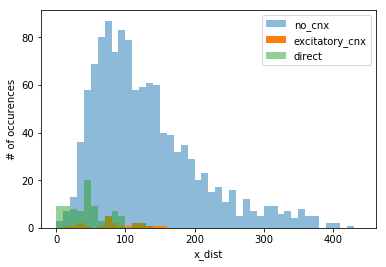

In [29]:
df=pyr

plt.hist(df[df['cnx']=='no cnx']['xy_dist'],bins=range(0,450,10),label='no_cnx',alpha=0.5)
plt.hist(df[df['cnx']=='excitatory']['xy_dist'],bins=range(0,450,10),label='excitatory_cnx')
plt.hist(df[df['cnx']=='tbd']['xy_dist'],bins=range(0,450,10),label='direct',alpha=0.5)


plt.xlabel('x_dist')
plt.ylabel('# of occurences')

plt.legend()
plt.show()

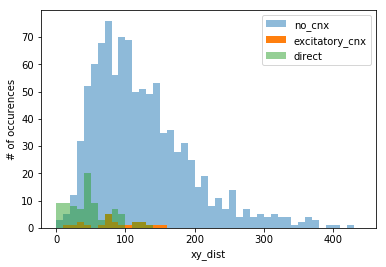

In [30]:
df=L5EtoE

plt.hist(df[df['cnx']=='no cnx']['xy_dist'],bins=range(0,450,10),label='no_cnx',alpha=0.5)
plt.hist(df[df['cnx']=='excitatory']['xy_dist'],bins=range(0,450,10),label='excitatory_cnx')
plt.hist(df[df['cnx']=='tbd']['xy_dist'],bins=range(0,450,10),label='direct',alpha=0.5)


plt.xlabel('xy_dist')
plt.ylabel('# of occurences')

plt.legend()
plt.show()

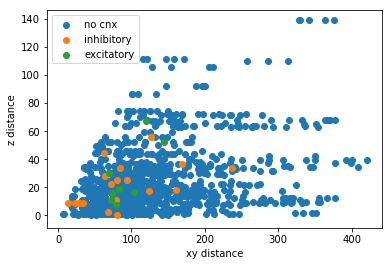

In [19]:
plt.scatter(pyr[pyr['cnx']=='no cnx']['xy_dist'],pyr[pyr['cnx']=='no cnx']['z_dist'], label='no cnx')

#plt.scatter(pyr[pyr['cnx']=='tbd']['xy_dist'],pyr[pyr['cnx']=='tbd']['z_dist'], label='direct')
plt.scatter(pyr[pyr['cnx']=='inhibitory']['xy_dist'],pyr[pyr['cnx']=='inhibitory']['z_dist'],label='inhibitory')
plt.scatter(pyr[pyr['cnx']=='excitatory']['xy_dist'], pyr[pyr['cnx']=='excitatory']['z_dist'],label='excitatory')
plt.xlabel('xy distance')
plt.ylabel('z distance')
plt.legend()
plt.show()

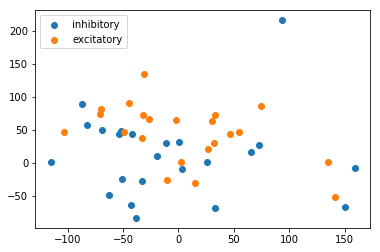

In [20]:
##plt.scatter(pyr[pyr['cnx']=='tbd']['X_rotate'],pyr[pyr['cnx']=='tbd']['Y_rotate'], label='direct')
plt.scatter(pyr[pyr['cnx']=='inhibitory']['X_rotate'],pyr[pyr['cnx']=='inhibitory']['Y_rotate'],label='inhibitory')
plt.scatter(pyr[pyr['cnx']=='excitatory']['X_rotate'], pyr[pyr['cnx']=='excitatory']['Y_rotate'],label='excitatory')
plt.legend()
plt.show()

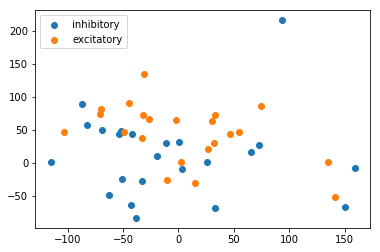

In [32]:
##plt.scatter(pyr[pyr['cnx']=='tbd']['X_rotate'],pyr[pyr['cnx']=='tbd']['Y_rotate'], label='direct')
plt.scatter(pyr[pyr['cnx']=='inhibitory']['X_rotate'],pyr[pyr['cnx']=='inhibitory']['Y_rotate'],label='inhibitory')
plt.scatter(pyr[pyr['cnx']=='excitatory']['X_rotate'], pyr[pyr['cnx']=='excitatory']['Y_rotate'],label='excitatory')
plt.legend()
plt.show()

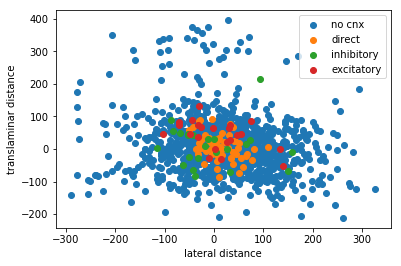

In [22]:
plt.scatter(pyr[pyr['cnx']=='no cnx']['X_rotate'],pyr[pyr['cnx']=='no cnx']['Y_rotate'], label='no cnx')

plt.scatter(pyr[pyr['cnx']=='tbd']['X_rotate'],pyr[pyr['cnx']=='tbd']['Y_rotate'], label='direct')
plt.scatter(pyr[pyr['cnx']=='inhibitory']['X_rotate'],pyr[pyr['cnx']=='inhibitory']['Y_rotate'],label='inhibitory')
plt.scatter(pyr[pyr['cnx']=='excitatory']['X_rotate'], pyr[pyr['cnx']=='excitatory']['Y_rotate'],label='excitatory')
plt.xlabel('lateral distance')
plt.ylabel('translaminar distance')
plt.legend()
plt.show()

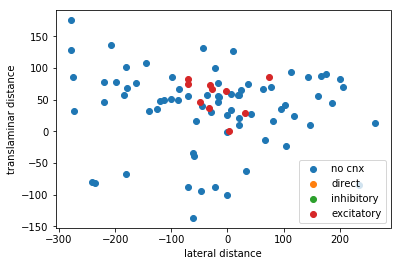

In [38]:
df=Slc2e[Slc2e['HS_reporter']=='neg']

plt.scatter(df[df['cnx']=='no cnx']['X_rotate'],df[df['cnx']=='no cnx']['Y_rotate'], label='no cnx')

plt.scatter(df[df['cnx']=='tbd']['X_rotate'],df[df['cnx']=='tbd']['Y_rotate'], label='direct')
plt.scatter(df[df['cnx']=='inhibitory']['X_rotate'],df[df['cnx']=='inhibitory']['Y_rotate'],label='inhibitory')
plt.scatter(df[df['cnx']=='excitatory']['X_rotate'], df[df['cnx']=='excitatory']['Y_rotate'],label='excitatory')
plt.xlabel('lateral distance')
plt.ylabel('translaminar distance')
plt.legend()
plt.show()

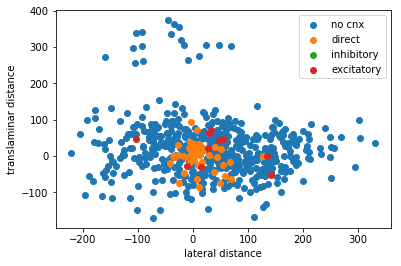

In [39]:
df=Slc2e[Slc2e['HS_reporter']=='pos']

plt.scatter(df[df['cnx']=='no cnx']['X_rotate'],df[df['cnx']=='no cnx']['Y_rotate'], label='no cnx')

plt.scatter(df[df['cnx']=='tbd']['X_rotate'],df[df['cnx']=='tbd']['Y_rotate'], label='direct')
plt.scatter(df[df['cnx']=='inhibitory']['X_rotate'],df[df['cnx']=='inhibitory']['Y_rotate'],label='inhibitory')
plt.scatter(df[df['cnx']=='excitatory']['X_rotate'], df[df['cnx']=='excitatory']['Y_rotate'],label='excitatory')
plt.xlabel('lateral distance')
plt.ylabel('translaminar distance')
plt.legend()
plt.show()

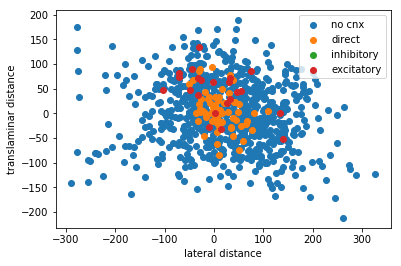

In [23]:
df=L5EtoE

plt.scatter(df[df['cnx']=='no cnx']['X_rotate'],df[df['cnx']=='no cnx']['Y_rotate'], label='no cnx')

plt.scatter(df[df['cnx']=='tbd']['X_rotate'],df[df['cnx']=='tbd']['Y_rotate'], label='direct')
plt.scatter(df[df['cnx']=='inhibitory']['X_rotate'],df[df['cnx']=='inhibitory']['Y_rotate'],label='inhibitory')
plt.scatter(df[df['cnx']=='excitatory']['X_rotate'], df[df['cnx']=='excitatory']['Y_rotate'],label='excitatory')
plt.xlabel('lateral distance')
plt.ylabel('translaminar distance')
plt.legend()
plt.show()

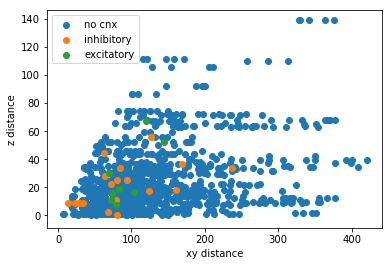

In [205]:
plt.scatter(pyr[pyr['cnx']=='no cnx']['xy_dist'],pyr[pyr['cnx']=='no cnx']['z_dist'], label='no cnx')

#plt.scatter(pyr[pyr['cnx']=='tbd']['xy_dist'],pyr[pyr['cnx']=='tbd']['z_dist'], label='direct')
plt.scatter(pyr[pyr['cnx']=='inhibitory']['xy_dist'],pyr[pyr['cnx']=='inhibitory']['z_dist'],label='inhibitory')
plt.scatter(pyr[pyr['cnx']=='excitatory']['xy_dist'], pyr[pyr['cnx']=='excitatory']['z_dist'],label='excitatory')
plt.xlabel('xy distance')
plt.ylabel('z distance')
plt.legend()
plt.show()

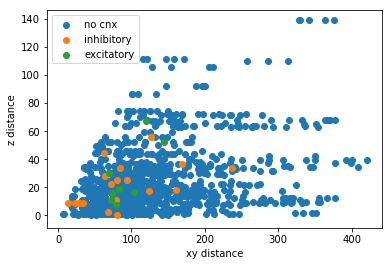

In [206]:
plt.scatter(pyr[pyr['cnx']=='no cnx']['xy_dist'],pyr[pyr['cnx']=='no cnx']['z_dist'], label='no cnx')

#plt.scatter(pyr[pyr['cnx']=='tbd']['xy_dist'],pyr[pyr['cnx']=='tbd']['z_dist'], label='direct')
plt.scatter(pyr[pyr['cnx']=='inhibitory']['xy_dist'],pyr[pyr['cnx']=='inhibitory']['z_dist'],label='inhibitory')
plt.scatter(pyr[pyr['cnx']=='excitatory']['xy_dist'], pyr[pyr['cnx']=='excitatory']['z_dist'],label='excitatory')
plt.xlabel('xy distance')
plt.ylabel('z distance')
plt.legend()
plt.show()

In [183]:
#plt.scatter(pyr[pyr['cnx']=='no cnx']['xy_dist'],pyr[pyr['cnx']=='no cnx']['z_dist'], label='no cnx')

#plt.scatter(pyr[pyr['cnx']=='tbd']['xy_dist'],pyr[pyr['cnx']=='tbd']['z_dist'], label='direct')
plt.scatter(pyr[pyr['cnx']=='inhibitory']['xy_dist'],pyr[pyr['cnx']=='inhibitory']['z_dist'],label='inhibitory')
plt.scatter(pyr[pyr['cnx']=='excitatory']['xy_dist'], pyr[pyr['cnx']=='excitatory']['z_dist'],label='excitatory')
m,b=np.polyfit(pyr[pyr['cnx']=='inhibitory']['xy_dist'],pyr[pyr['cnx']=='inhibitory']['z_dist'],1)
print m
print b
plt.xlabel('xy distance')
plt.ylabel('z distance')
plt.legend()
plt.show()

ValueError: On entry to DGELSD parameter number 6 had an illegal value

In [165]:
def exp_plots_group(exp_df):
    groups=exp_df.groupby('cnx')
    for name, group in groups:
        plt.scatter(group.X_rotate, group.Y_rotate, label=name, alpha=0.3)
    plt.xlabel('x location')
    plt.ylabel('y location')
    plt.legend()
    plt.show()


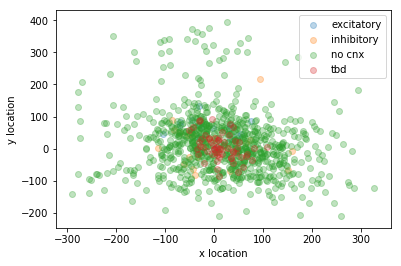

In [207]:
exp_plots_group(pyr)